<a href="https://colab.research.google.com/github/arawsardni/Skin-Cancer-Classification---IS-LAB-Intern-Project/blob/main/skin_cancer_classification_notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Import Library**

In [12]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import pandas as pd
import os
from PIL import Image
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Dataset, random_split
from sklearn.model_selection import train_test_split

# **Set SEED**

In [ ]:
import random
import numpy as np

# --- Menetapkan Random Seed untuk Reproducibility ---
def set_seed(seed_value=42):
    """Menetapkan seed untuk semua library yang relevan agar hasil dapat direproduksi."""
    random.seed(seed_value)
    np.random.seed(seed_value)
    torch.manual_seed(seed_value)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed_value)
        torch.cuda.manual_seed_all(seed_value)  # untuk multi-GPU
        # Pengaturan ini penting untuk determinisme penuh saat menggunakan CUDA
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False

# Panggil fungsi untuk menetapkan seed di seluruh notebook
SEED = 42
set_seed(SEED)
print(f"Random seed telah ditetapkan ke {SEED} untuk reproducibility.")


# **Load Dataset**

In [2]:
import kagglehub
path = kagglehub.dataset_download("kmader/skin-cancer-mnist-ham10000")
print("Path to dataset files:", path)

Using Colab cache for faster access to the 'skin-cancer-mnist-ham10000' dataset.
Path to dataset files: /kaggle/input/skin-cancer-mnist-ham10000


In [3]:
class HAM10000Dataset(Dataset):
    def __init__(self, df, img_dir, transform=None):
        self.df = df
        self.img_dir = img_dir
        self.transform = transform
        # buat pemetaan dari path gambar ke ID gambar untuk pencarian cepat
        self.image_paths = {os.path.basename(p).replace('.jpg', ''): os.path.join(d, p)
                            for d, _, files in os.walk(img_dir) for p in files if p.endswith('.jpg')}
        # encode label target
        self.lesion_type_dict = {
            'nv': 0, 'mel': 1, 'bkl': 2, 'bcc': 3, 'akiec': 4, 'vasc': 5, 'df': 6
        }
        self.df['label'] = self.df['dx'].map(self.lesion_type_dict)

    def __len__(self):
        return len(self.df)

    def __getitem__(self, index):
        img_id = self.df.iloc[index]['image_id']
        label = self.df.iloc[index]['label']
        img_path = self.image_paths.get(img_id)

        if not img_path:
            # handle jika path tidak ditemukan (misalnya, jika ada ID di CSV tapi tidak ada file gambarnya)
            print(f"Warning: Image path for {img_id} not found.")
            # kembalikan tensor kosong atau handle error lain
            return torch.zeros(3, 224, 224), -1

        image = Image.open(img_path).convert('RGB')

        if self.transform:
            image = self.transform(image)

        return image, label

# **EDA**

## **Transform Image**

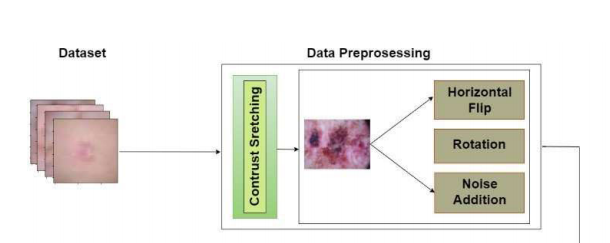

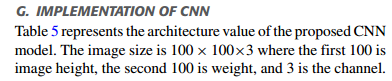

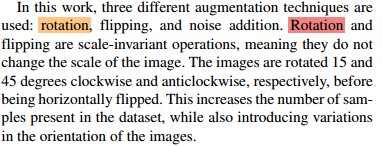

In [4]:
# Paper menggunakan ukuran 100x100
train_transforms = transforms.Compose([
    transforms.Resize((100, 100)),
    transforms.RandomChoice([
        transforms.RandomRotation(degrees=[15, 15]),    # Rotasi +15 derajat
        transforms.RandomRotation(degrees=[-15, -15]),  # Rotasi -15 derajat
        transforms.RandomRotation(degrees=[45, 45]),    # Rotasi +45 derajat
        transforms.RandomRotation(degrees=[-45, -45]),  # Rotasi -45 derajat
        transforms.RandomRotation(degrees=[0, 0]),      # Opsi untuk tidak merotasi sama sekali
    ]),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.1), # Representasi "noise addition"
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# untuk validation dan test set, kita tidak melakukan augmentasi, hanya resize dan normalisasi
val_test_transforms = transforms.Compose([
    transforms.Resize((100, 100)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

## **Load Metadata**

In [6]:
# --- Memuat Metadata dan Membagi Data ---
data_dir = '/kaggle/input/skin-cancer-mnist-ham10000'
metadata = pd.read_csv(os.path.join(data_dir, 'HAM10000_metadata.csv'))

## **Data Splitting**

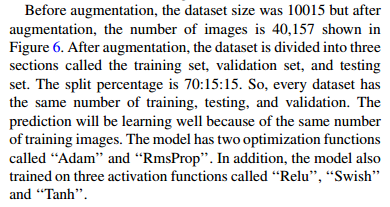

di dalam paper disebutkan bahwa mereka melakukan augnmentasi dataset dengan melakukan rotasi pada gambar, namun untuk percobaan ini kita tidak melakukan augmentasi tersebut dan langsung split dataa dari 10015 data yang ada dulu sebagai baseline

In [7]:
train_df, val_test_df = train_test_split(
    metadata,
    test_size=0.30,
    random_state=SEED,
    stratify=metadata['dx']
)

val_df, test_df = train_test_split(
    val_test_df,
    test_size=0.50,
    random_state=SEED,
    stratify=val_test_df['dx']
)

In [8]:
train_dataset = HAM10000Dataset(df=train_df, img_dir=data_dir, transform=train_transforms)
val_dataset = HAM10000Dataset(df=val_df, img_dir=data_dir, transform=val_test_transforms)
test_dataset = HAM10000Dataset(df=test_df, img_dir=data_dir, transform=val_test_transforms)

## **Data Loading**

In [9]:
# --- Membuat DataLoader ---
batch_size = 64 # tidak dituliskan di paper, kami gunakan yg umum digunakan
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

# --- Cetak Informasi ---
class_names = list(train_dataset.lesion_type_dict.keys())
total_data = len(metadata)
print(f"Jumlah total data: {total_data}")
print(f"Data Training  : {len(train_dataset)} ({len(train_dataset)/total_data:.0%})")
print(f"Data Validasi  : {len(val_dataset)} ({len(val_dataset)/total_data:.0%})")
print(f"Data Testing   : {len(test_dataset)} ({len(test_dataset)/total_data:.0%})")
print(f"Kelas yang terdeteksi: {class_names}")

Jumlah total data: 10015
Data Training  : 7010 (70%)
Data Validasi  : 1502 (15%)
Data Testing   : 1503 (15%)
Kelas yang terdeteksi: ['nv', 'mel', 'bkl', 'bcc', 'akiec', 'vasc', 'df']


## **CNN Architecture**

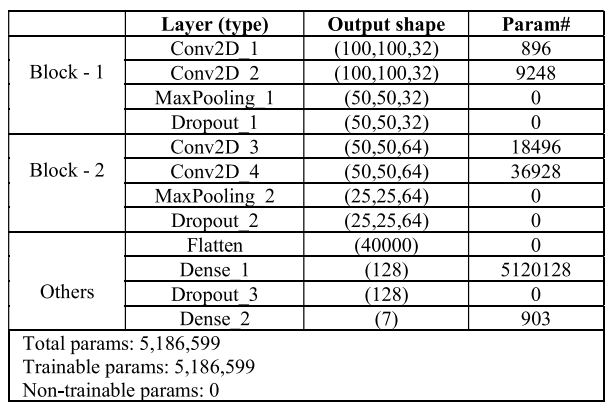

In [10]:
class OptimizedCNN(nn.Module):
    def __init__(self):
        super(OptimizedCNN, self).__init__()
        # Arsitektur sama persis dengan Tabel 5 dari paper

        # Block 1
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 32, kernel_size  =3, padding=1)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.dropout1 = nn.Dropout(0.25)

        # Block 2
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.conv4 = nn.Conv2d(64, 64, kernel_size=3, padding=1)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.dropout2 = nn.Dropout(0.25)

        # Flatten dan Fully Connected Layers
        self.flatten = nn.Flatten()

        # Kalkulasi input untuk fc1:
        # Ukuran input: 100x100. Setelah 2x MaxPool (2x2), ukuran menjadi (100/2)/2 = 25.
        # Ukuran fitur: 64 filter * 25 * 25 = 40000. Ini cocok dengan shape 'Flatten' di Tabel 5.
        self.fc1 = nn.Linear(64 * 25 * 25, 128)
        self.dropout3 = nn.Dropout(0.5)
        self.fc2 = nn.Linear(128, 7)

    def forward(self, x):
        # Menggunakan aktivasi ReLU, sesuai optimasi terbaik paper
        x = F.relu(self.pool1(F.relu(self.conv2(F.relu(self.conv1(x))))))
        x = self.dropout1(x)

        x = F.relu(self.pool2(F.relu(self.conv4(F.relu(self.conv3(x))))))
        x = self.dropout2(x)

        x = self.flatten(x)
        x = F.relu(self.fc1(x))
        x = self.dropout3(x)
        x = self.fc2(x)
        return x



In [13]:
# Inisialisasi baseline_model dan pindahkan ke GPU jika tersedia
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
baseline_model = OptimizedCNN().to(device)
print(baseline_model)
print(f"\nMenggunakan device: {device}")

# --- Mendefinisikan Loss Function dan Optimizer (Adam) ---
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(baseline_model.parameters(), lr=0.001)

OptimizedCNN(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout1): Dropout(p=0.25, inplace=False)
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout2): Dropout(p=0.25, inplace=False)
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc1): Linear(in_features=40000, out_features=128, bias=True)
  (dropout3): Dropout(p=0.5, inplace=False)
  (fc2): Linear(in_features=128, out_features=7, bias=True)
)

Menggunakan device: cuda:0


## **Training Model**

In [16]:
import torch.optim as optim
from tqdm import tqdm
import numpy as np

# --- Inisialisasi list untuk menyimpan riwayat training ---
train_loss_history = []
train_acc_history = []
val_loss_history = []
val_acc_history = []

# --- Training Loop ---
num_epochs = 100
best_val_acc = 0.0
baseline_model_path = "baseline_model.pth"

for epoch in range(num_epochs):
    # --- Training Phase ---
    baseline_model.train()
    running_loss = 0.0
    train_correct = 0

    train_pbar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Training]", leave=False)
    for inputs, labels in train_pbar:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = baseline_model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)
        _, predicted = torch.max(outputs.data, 1)
        train_correct += (predicted == labels).sum().item()
        train_pbar.set_postfix({'loss': f'{loss.item():.4f}'})

    epoch_train_loss = running_loss / len(train_dataset)
    epoch_train_acc = train_correct / len(train_dataset)

    # --- Validation Phase ---
    baseline_model.eval()
    val_loss = 0.0
    val_correct = 0

    with torch.no_grad():
        # Menambahkan tqdm untuk validation loader
        val_pbar = tqdm(val_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Validation]", leave=False)
        for inputs, labels in val_pbar:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = baseline_model(inputs)
            loss = criterion(outputs, labels)

            val_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs.data, 1)
            val_correct += (predicted == labels).sum().item()
            # Anda juga bisa menambahkan postfix di sini jika ingin
            val_pbar.set_postfix({'loss': f'{loss.item():.4f}'})

    epoch_val_loss = val_loss / len(val_dataset)
    epoch_val_acc = val_correct / len(val_dataset)

    # --- Menyimpan Riwayat Metrik ---
    train_loss_history.append(epoch_train_loss)
    train_acc_history.append(epoch_train_acc)
    val_loss_history.append(epoch_val_loss)
    val_acc_history.append(epoch_val_acc)

    print(f'Epoch {epoch+1}/{num_epochs} | Train Loss: {epoch_train_loss:.4f} | Train Acc: {epoch_train_acc:.4f} | Val Loss: {epoch_val_loss:.4f} | Val Acc: {epoch_val_acc:.4f}')

    # Simpan baseline_model jika akurasi validasi membaik
    if epoch_val_acc > best_val_acc:
        best_val_acc = epoch_val_acc
        torch.save(baseline_model.state_dict(), baseline_model_path)
        print(f"Model terbaik disimpan di {baseline_model_path} dengan Val Acc: {best_val_acc:.4f}")

print('\nPelatihan Selesai')

Epoch 1/100 | Train Loss: 0.8688 | Train Acc: 0.6893 | Val Loss: 0.8110 | Val Acc: 0.7097
Model terbaik disimpan di baseline_model.pth dengan Val Acc: 0.7097


KeyboardInterrupt: 

In [ ]:
import matplotlib.pyplot as plt

# Membuat plot untuk Akurasi
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(range(1, num_epochs + 1), train_acc_history, label='Training Accuracy')
plt.plot(range(1, num_epochs + 1), val_acc_history, label='Validation Accuracy')
plt.title('Training vs Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

# Membuat plot untuk Loss
plt.subplot(1, 2, 2)
plt.plot(range(1, num_epochs + 1), train_loss_history, label='Training Loss')
plt.plot(range(1, num_epochs + 1), val_loss_history, label='Validation Loss')
plt.title('Training vs Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


--- Memulai Evaluasi pada Test Set ---


Testing: 100%|██████████| 47/47 [00:13<00:00,  3.39it/s]


Hasil Evaluasi Test Set:
Test Loss: 0.9323
Test Accuracy: 0.6826 (68.26%)


In [ ]:
from sklearn.metrics import confusion_matrix
import numpy as np

all_preds = []
all_labels = []

with torch.no_grad():
    for inputs, labels in tqdm(test_loader, desc="Generating Confusion Matrix"):
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = baseline_model(inputs)
        _, predicted = torch.max(outputs.data, 1)

        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

conf_matrix = confusion_matrix(all_labels, all_preds)

print("\nConfusion Matrix:")
print(conf_matrix)

## Define ResNet50 Model



In [ ]:
import torch.nn as nn
import torchvision.models as models

class ResNetClassifier(nn.Module):
    def __init__(self, num_classes=7):
        super(ResNetClassifier, self).__init__()
        self.resnet = models.resnet50(pretrained=True)

        num_ftrs = self.resnet.fc.in_features
        self.resnet.fc = nn.Linear(num_ftrs, num_classes)

    def forward(self, x):
        return self.resnet(x)

## Inisialisasi model ResNet50


In [ ]:
resnet_model = ResNetClassifier(num_classes=7)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

resnet_model.to(device)
print(resnet_model)
print(f"\nUsing device: {device}")

/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


100%|██████████| 97.8M/97.8M [00:00<00:00, 161MB/s]


ResNetClassifier(
  (resnet): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
  

## Loss Function & Optimizer




In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(resnet_model.parameters(), lr=0.001)
print("Loss function and optimizer defined.")

## Training & Validasi



In [ ]:
num_epochs = 50 # Ngutek-ngutek epoch
best_val_acc = 0.0
best_model_path = "best_resnet_model.pth"

for epoch in range(num_epochs):
    resnet_model.train()
    running_loss = 0.0
    train_correct = 0

    train_pbar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Training]", leave=False)
    for inputs, labels in train_pbar:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = resnet_model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)
        _, predicted = torch.max(outputs.data, 1)
        train_correct += (predicted == labels).sum().item()
        train_pbar.set_postfix({'loss': f'{loss.item():.4f}'})

    epoch_train_loss = running_loss / len(train_dataset)
    epoch_train_acc = train_correct / len(train_dataset)

    resnet_model.eval()
    val_loss = 0.0
    val_correct = 0

    with torch.no_grad():
        val_pbar = tqdm(val_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Validation]", leave=False)
        for inputs, labels in val_pbar:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = resnet_model(inputs)
            loss = criterion(outputs, labels)

            val_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs.data, 1)
            val_correct += (predicted == labels).sum().item()
            val_pbar.set_postfix({'loss': f'{loss.item():.4f}'})


    epoch_val_loss = val_loss / len(val_dataset)
    epoch_val_acc = val_correct / len(val_dataset)

    print(f'Epoch {epoch+1}/{num_epochs} | Train Loss: {epoch_train_loss:.4f} | Train Acc: {epoch_train_acc:.4f} | Val Loss: {epoch_val_loss:.4f} | Val Acc: {epoch_val_acc:.4f}')

    if epoch_val_acc > best_val_acc:
        best_val_acc = epoch_val_acc
        torch.save(resnet_model.state_dict(), best_model_path)
        print(f"Model terbaik disimpan di {best_model_path} dengan Val Acc: {best_val_acc:.4f}")

print('\nPelatihan Selesai')

## Evaluasi Akhir



In [ ]:
print("\n--- Starting Evaluation on Test Set ---")
best_resnet_model_path = "best_resnet_model.pth"
resnet_model.load_state_dict(torch.load(best_resnet_model_path))

resnet_model.eval()

test_loss = 0.0
test_correct = 0

with torch.no_grad():
    for inputs, labels in tqdm(test_loader, desc="Testing ResNet"):
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = resnet_model(inputs)
        loss = criterion(outputs, labels)

        test_loss += loss.item() * inputs.size(0)
        _, predicted = torch.max(outputs.data, 1)
        test_correct += (predicted == labels).sum().item()

final_test_loss = test_loss / len(test_dataset)
final_test_acc = test_correct / len(test_dataset)

print(f'\nFinal Test Set Evaluation Results:')
print(f'Test Loss: {final_test_loss:.4f}')
print(f'Test Accuracy: {final_test_acc:.4f} ({final_test_acc*100:.2f}%)')

## Summary:

### Data Analysis Key Findings

* Model ResNetClassifier berhasil diinisialisasi dengan 7 kelas output dan dipindahkan ke GPU (`cuda:0`).
* Proses pelatihan menggunakan fungsi CrossEntropyLoss dan optimizer Adam dengan learning rate 0.001.
* Model dilatih selama 50 epoch dan model terbaik berdasarkan akurasi validasi disimpan di `best_resnet_model.pth`.
* Evaluasi akhir pada test set menggunakan model terbaik menghasilkan Test Loss sebesar 0.5983 dan Test Accuracy sebesar 0.7997 (79.97%).

### Insights or Next Steps

* Model ResNet50 mencapai akurasi yang lebih baik (79.97%) pada test set dibandingkan dengan model CNN sebelumnya (66.93%), menunjukkan potensi arsitektur yang lebih kompleks.
* Peningkatan lebih lanjut dapat dieksplorasi dengan:
    * Fine-tuning model ResNet50 yang sudah dilatih sebelumnya dengan dataset yang lebih besar atau dengan teknik transfer learning yang berbeda.
    * Eksperimen dengan hyperparameter lain seperti learning rate, optimizer, atau scheduler learning rate.
    * Menerapkan teknik data augmentation yang lebih beragam dan agresif.
    * Menangani ketidakseimbangan kelas (jika ada) dalam dataset menggunakan teknik seperti oversampling, undersampling, atau weighted loss.
    * Mengevaluasi model menggunakan metrik lain seperti F1-score, precision, dan recall, terutama jika ada ketidakseimbangan kelas.

## Analisis Mendalam confusion matrix untuk memahami kelas mana yang sulit diprediksi oleh model



In [ ]:
from sklearn.metrics import confusion_matrix
import numpy as np

all_preds = []
all_labels = []

with torch.no_grad():
    for inputs, labels in tqdm(test_loader, desc="Generating Confusion Matrix"):
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = resnet_model(inputs)
        _, predicted = torch.max(outputs.data, 1)

        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

conf_matrix = confusion_matrix(all_labels, all_preds)

print("\nConfusion Matrix:")
print(conf_matrix)

Generating Confusion Matrix: 100%|██████████| 47/47 [00:10<00:00,  4.51it/s]


Confusion Matrix:
[[138 166 414   6 204  22  56]
 [  7  30  88   1  31   0  10]
 [  7  23  96   1  30   1   7]
 [ 12   9  39   0  12   0   5]
 [  0   6  35   0   3   0   5]
 [  2   5   9   0   6   0   0]
 [  1   1  11   0   4   0   0]]


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# --- Letakkan kode ini setelah Anda menghitung conf_matrix ---

# Nama kelas diambil dari dictionary yang sudah Anda buat sebelumnya
class_names = list(train_dataset.lesion_type_dict.keys())

# Membuat plot
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)

# Menambahkan judul dan label
plt.title('Confusion Matrix Hasil Evaluasi Test Set', fontsize=16)
plt.ylabel('Label Sebenarnya (Actual)', fontsize=12)
plt.xlabel('Label Prediksi (Predicted)', fontsize=12)

# Menampilkan plot
plt.show()

## Peningkatan Data Augmentasi



In [ ]:
aggressive_train_transforms = transforms.Compose([
    transforms.Resize((100, 100)),
    transforms.RandomApply([
        transforms.RandomRotation(degrees=60), # Increased rotation range
        transforms.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.3, hue=0.3), # More significant color jitter
        transforms.RandomResizedCrop(size=100, scale=(0.8, 1.0)), # Random crop
    ], p=0.5), # Apply augmentation with a probability
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(), # Added vertical flip
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

aggressive_train_dataset = HAM10000Dataset(df=train_df, img_dir=data_dir, transform=aggressive_train_transforms)

aggressive_train_loader = DataLoader(aggressive_train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)

print("New data loaders with aggressive augmentation for training have been set up.")

New data loaders with aggressive augmentation for training have been set up.


## Penanganan Ketidakseimbangan Kelas (oversampling, undersampling, atau weighted loss).


In [ ]:
class_counts = train_df['dx'].value_counts()
print("Class distribution in training data:")
print(class_counts)

num_classes = len(class_names)
print(f"\nNumber of classes: {num_classes}")

min_count = class_counts.min()
max_count = class_counts.max()
print(f"Smallest class count: {min_count}")
print(f"Largest class count: {max_count}")

if max_count / min_count > 5: # Simple heuristic for significant imbalance
    print("\nSignificant class imbalance detected. Calculating class weights.")
    total_samples = len(train_df)
    class_weights = total_samples / (num_classes * class_counts.sort_index())
    class_weights = torch.tensor(class_weights.values, dtype=torch.float32)
    print("Calculated class weights:")
    print(class_weights)

    criterion = nn.CrossEntropyLoss(weight=class_weights.to(device))
    print("\nCrossEntropyLoss updated with class weights.")
else:
    print("\nClass imbalance is not considered significant enough for weighting based on the heuristic.")
    criterion = nn.CrossEntropyLoss()
    print("\nCrossEntropyLoss is using default weights.")


Class distribution in training data:
dx
nv       4693
mel       779
bkl       769
bcc       360
akiec     229
vasc       99
df         81
Name: count, dtype: int64

Number of classes: 7
Smallest class count: 81
Largest class count: 4693

Significant class imbalance detected. Calculating class weights.
Calculated class weights:
tensor([ 4.3731,  2.7817,  1.3022, 12.3633,  1.2855,  0.2134, 10.1154])

CrossEntropyLoss updated with class weights.
